Primeiro teste com variação padrão

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge
rpy.set_seed(42)

In [3]:
from sklearn.metrics import r2_score 
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_squared_error
    

In [4]:
def plotfig(a, b, c, time, sinal, Label, cor, xlabel, ylabel, title):
    plt.figure(figsize=(12,6))
    plt.subplot(a, b, c)  # (n_linhas, n_colunas, índice)
    plt.plot(time, sinal, label=Label, color=cor)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

def NRMSE(y, y_esn):
    y_min = np.min(y)
    y_max = np.max(y)
    nrmse = np.sqrt( (1/len(y) * np.sum( np.abs((y-y_esn)/(y_max-y_min) )**2 ) ) )   
    return(nrmse) 

# SINAL APRBS DO BCS

In [5]:
# Parâmetros do sinal 
t_final, dt = 10000, 2             # final e passo
t = np.arange(0, t_final, dt)
min_step, max_step = 600/60, 6000/60 # tempo entre trocas 


FRENQUÊNCIA:

In [6]:
# Sinal de Frequência APRBS
min_value_f, max_value_f = 35, 60   # limites
f = np.zeros_like(t)

current_value = np.random.uniform(min_value_f, max_value_f)
time_next_change = 0

for i in range(len(t)):
    if t[i] >= time_next_change:
        current_value = np.random.uniform(min_value_f, max_value_f)
        time_next_change = t[i] + np.random.uniform(min_step, max_step)
        #print(time_next_change-t[i])
    f[i] = current_value


ABERTURA DE VÁLVULA:

In [7]:
# Sinal de Abertura APRBS
min_value_zc, max_value_zc = 5, 100   # limites
Zc = np.zeros_like(t)

current_value = np.random.uniform(min_value_zc, max_value_zc)
time_next_change = 0

for i in range(len(t)):
    if t[i] >= time_next_change:
        current_value = np.random.uniform(min_value_zc, max_value_zc)
        time_next_change = t[i] + np.random.uniform(min_step, max_step)
        #print(time_next_change-t[i])
    Zc[i] = current_value

ARQUIVO CSV:

In [8]:
Entradas = pd.DataFrame({
    "f(Hz)": f,
    "Zc(%)": Zc
}) 
Entradas.to_csv("Entradas_3_BCS.csv", index=False)

# IMPORTE RESPOSTAS

In [9]:
Saidas = pd.read_excel("Saidas_3_xlsx.xlsx")
Saidas = Saidas.to_numpy()
#Saidas = np.repeat(Saidas, 2, axis=0)
Entradas = Entradas.to_numpy()
P_in = Saidas[:,0].reshape(-1,1)
H = Saidas[:,1].reshape(-1,1)
print(P_in.shape)
print(H.shape)

(5000, 1)
(5000, 1)


# NORMALIZAÇÃO

In [10]:
scaler_in = MinMaxScaler(feature_range=(-1, 1))
Entradas_norm = scaler_in.fit_transform(Entradas)   # entradas normalizadas

scaler_out = MinMaxScaler(feature_range=(-1, 1))
Saidas_norm = scaler_out.fit_transform(Saidas)   # saídas normalizadas

DIVISÃO DE DADOS:

In [11]:
x_aux, y_aux = Entradas_norm[2500:], Saidas_norm[2500:]
# Treino 
X_train, Y_train = Entradas_norm[:2500], Saidas_norm[:2500]
# Teste
X_test, Y_test = x_aux[:1250], y_aux[:1250]
# Validação
X_valid, Y_valid = x_aux[1250:], y_aux[1250:]

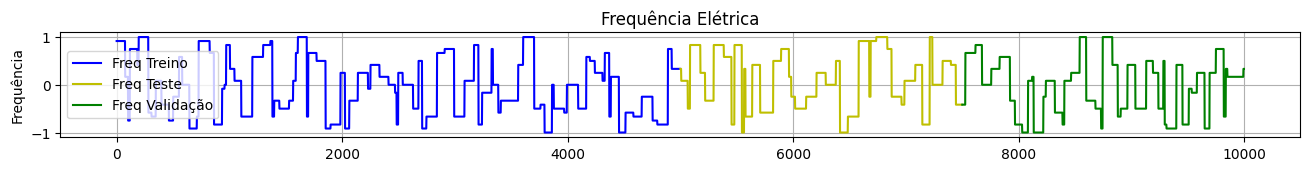

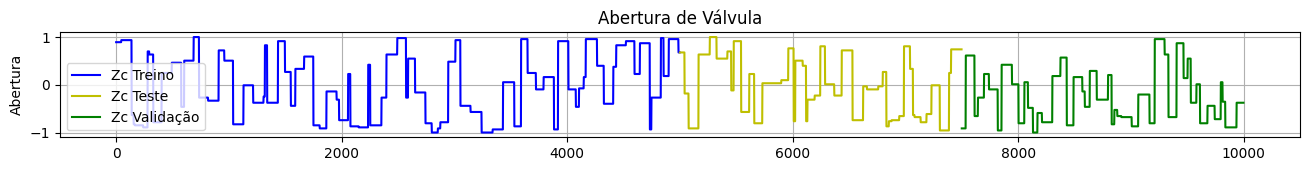

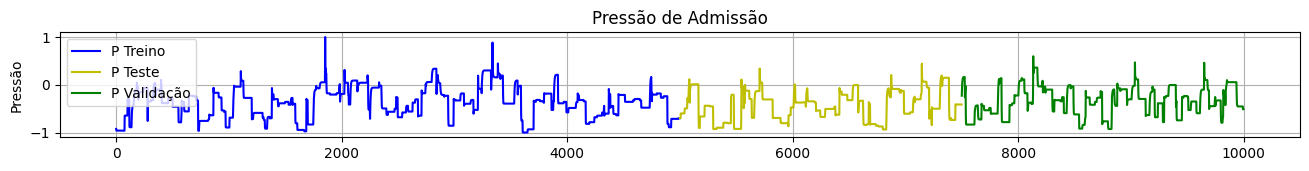

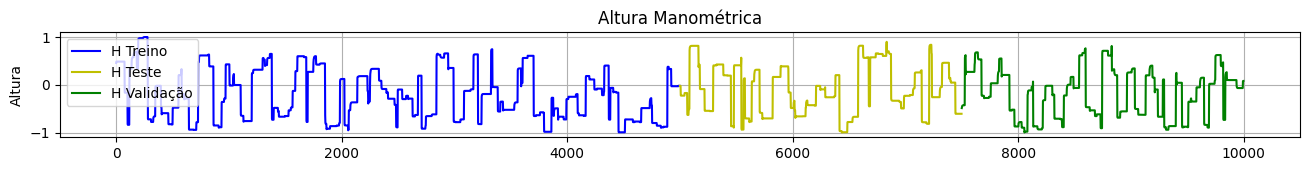

In [12]:
t_a = np.arange(0, t_final/2, 2)
t_b = np.arange(t_final/2, 3*t_final/4, 2)
t_c = np.arange(3*t_final/4, t_final, 2)

plt.figure(figsize=(16,3))
plt.subplot(2, 1, 1)  # (n_linhas, n_colunas, índice)
plt.plot(t_a, X_train[:,0], label="Freq Treino", color='b')
plt.plot(t_b, X_test[:,0], label="Freq Teste", color='y')
plt.plot(t_c, X_valid[:,0], label="Freq Validação", color='g')
plt.ylabel("Frequência")
plt.title("Frequência Elétrica")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(16,3))
plt.subplot(2, 1, 2)  # (n_linhas, n_colunas, índice)
plt.plot(t_a, X_train[:,1], label="Zc Treino", color='b')
plt.plot(t_b, X_test[:,1], label="Zc Teste", color='y')
plt.plot(t_c, X_valid[:,1], label="Zc Validação", color='g')
plt.ylabel("Abertura")
plt.title("Abertura de Válvula")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(16,3))
plt.subplot(2, 1, 1)  # (n_linhas, n_colunas, índice)
plt.plot(t_a, Y_train[:,0], label="P Treino", color='b')
plt.plot(t_b, Y_test[:,0], label="P Teste", color='y')
plt.plot(t_c, Y_valid[:,0], label="P Validação", color='g')
plt.ylabel("Pressão")
plt.title("Pressão de Admissão")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(16,3))
plt.subplot(2, 1, 2)  # (n_linhas, n_colunas, índice)
plt.plot(t_a, Y_train[:,1], label="H Treino", color='b')
plt.plot(t_b, Y_test[:,1], label="H Teste", color='y')
plt.plot(t_c, Y_valid[:,1], label="H Validação", color='g')
plt.ylabel("Altura")
plt.title("Altura Manométrica")
plt.grid(True)
plt.legend()
plt.show()


# GERANDO MODELO

In [13]:
R2_p, R2_h = 0, 0
i = 0
melhor_R2 = -1
melhor_param = {}

while (R2_p < 0.83 or R2_h < 0.9) and i < 500:
    # Definindo parâmetros
    # seed = int(np.random.uniform(1, 100))
    units = int(np.random.uniform(10,300))
    alpha = np.random.uniform(0, 1)
    # raio = np.random.uniform(0, 1)
    raio = 0.9

    # Gerando modelo
    #rpy.set_seed(int(seed))
    reservoir = Reservoir(units, lr = alpha, sr = raio)

    readout = Ridge(ridge=1e0)
    BCS_model = reservoir >> readout

    # Treino
    BCS_model = BCS_model.fit(X_train, Y_train, warmup=0)
    #print(reservoir.initialized, readout.initialized)

    # Teste
    Y_pred = BCS_model.run(X_test)
    R2_p = r2_score(Y_test[:,0], Y_pred[:,0])
    R2_h = r2_score(Y_test[:,1], Y_pred[:,1])
    R2  = [R2_p, R2_h]

    rmse_p = NRMSE(Y_test[:,0], Y_pred[:,0])
    rmse_h = NRMSE(Y_test[:,1], Y_pred[:,1])
    nrmse = [float(rmse_p), float(rmse_h)]
    
    print(f"Iteração {i+1:03d} | R²(P)={R2_p:.3f} | R²(H)={R2_h:.3f}")

    # Melhor modelo
    if (R2_p + R2_h)/2 > melhor_R2:
        melhor_R2 = (R2_p + R2_h)/2
        melhor_param = {
            #"seed": seed,
            "units": units,
            "alpha": alpha,
            "raio": raio,
            "R²": R2,
            "NRMSE": nrmse,
            "Iteração": i+1
        }
    i+=1
print("----------------------------------------\nMelhor modelo encontrado:")
for k, v in melhor_param.items():
    print(f"{k}: {v}")

Iteração 001 | R²(P)=0.801 | R²(H)=0.985
Iteração 002 | R²(P)=0.808 | R²(H)=0.984
Iteração 003 | R²(P)=0.819 | R²(H)=0.982
Iteração 004 | R²(P)=0.814 | R²(H)=0.985
Iteração 005 | R²(P)=0.797 | R²(H)=0.985
Iteração 006 | R²(P)=0.786 | R²(H)=0.984
Iteração 007 | R²(P)=0.789 | R²(H)=0.965
Iteração 008 | R²(P)=0.771 | R²(H)=0.953
Iteração 009 | R²(P)=0.789 | R²(H)=0.985
Iteração 010 | R²(P)=0.801 | R²(H)=0.983
Iteração 011 | R²(P)=0.773 | R²(H)=0.948
Iteração 012 | R²(P)=0.782 | R²(H)=0.977
Iteração 013 | R²(P)=0.785 | R²(H)=0.984
Iteração 014 | R²(P)=0.814 | R²(H)=0.985
Iteração 015 | R²(P)=0.787 | R²(H)=0.983
Iteração 016 | R²(P)=0.807 | R²(H)=0.981
Iteração 017 | R²(P)=0.821 | R²(H)=0.979
Iteração 018 | R²(P)=0.810 | R²(H)=0.984
Iteração 019 | R²(P)=0.798 | R²(H)=0.982
Iteração 020 | R²(P)=0.809 | R²(H)=0.983
Iteração 021 | R²(P)=0.809 | R²(H)=0.984
Iteração 022 | R²(P)=0.813 | R²(H)=0.984
Iteração 023 | R²(P)=0.804 | R²(H)=0.979
Iteração 024 | R²(P)=0.785 | R²(H)=0.984
Iteração 025 | R

VALIDAÇÃO:

(1250, 2)


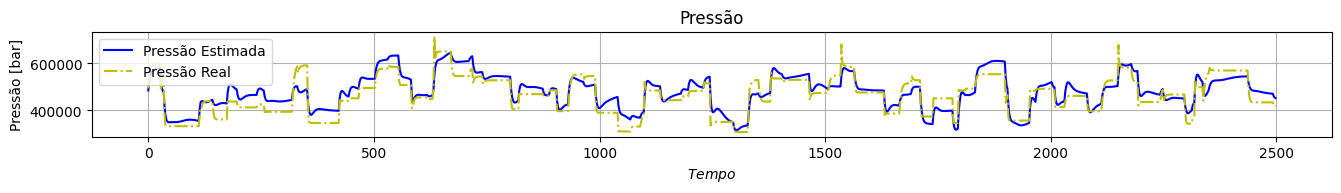

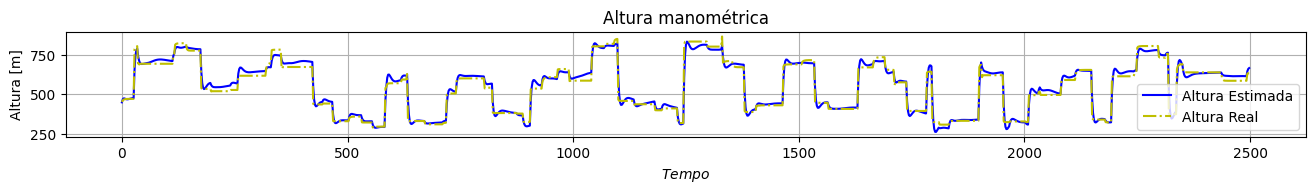

R²: [0.7673051833537018, 0.9724159135410847]
NRMSE: [0.09430708614792924, 0.0452800855693624]


In [14]:
Y_pred = BCS_model.run(X_valid)
print(Y_pred.shape)
Y_pred = scaler_out.inverse_transform(Y_pred)
Y_valid = scaler_out.inverse_transform(Y_valid)
t_ = np.arange(0, t_final/4, dt)

plt.figure(figsize=(16,3))
plt.subplot(2, 1, 1) 
plt.title("Pressão")
plt.xlabel("$Tempo$")
plt.ylabel("Pressão [bar]")
plt.plot(t_, Y_pred[:,0]/(10^(5)), label="Pressão Estimada", color="blue", linestyle="-")
plt.plot(t_, Y_valid[:,0]/(10^(5)), label="Pressão Real", color="y", linestyle="-.")
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(16,3))
plt.subplot(2, 1, 2) 
plt.title("Altura manométrica")
plt.xlabel("$Tempo$")
plt.ylabel("Altura [m]")
plt.plot(t_, Y_pred[:,1], label="Altura Estimada", color="blue", linestyle="-")
plt.plot(t_, Y_valid[:,1], label="Altura Real", color="y", linestyle="-.")
plt.grid()
plt.legend()
plt.show()

R2_p = r2_score(Y_valid[:,0], Y_pred[:,0])
R2_h = r2_score(Y_valid[:,1], Y_pred[:,1])
R2  = [R2_p, R2_h]
print(f"R²: {R2}")

rmse_p = NRMSE(Y_valid[:,0], Y_pred[:,0])
rmse_h = NRMSE(Y_valid[:,1], Y_pred[:,1])
nrmse = [float(rmse_p), float(rmse_h)]
print(f"NRMSE: {nrmse}")

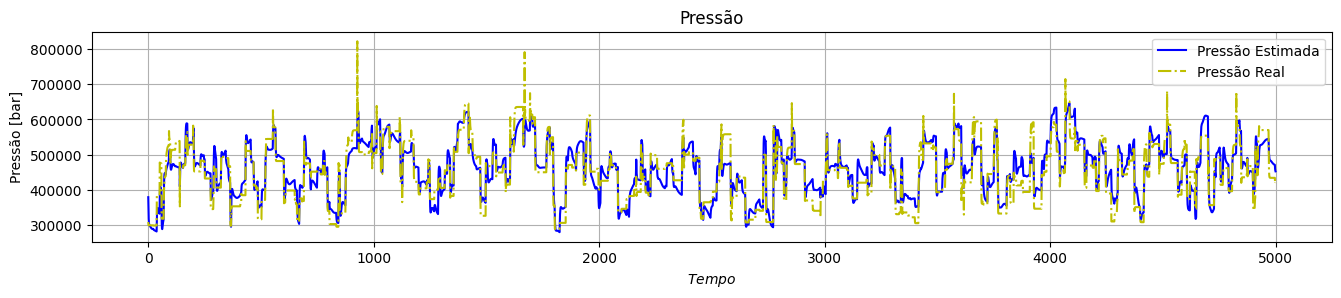

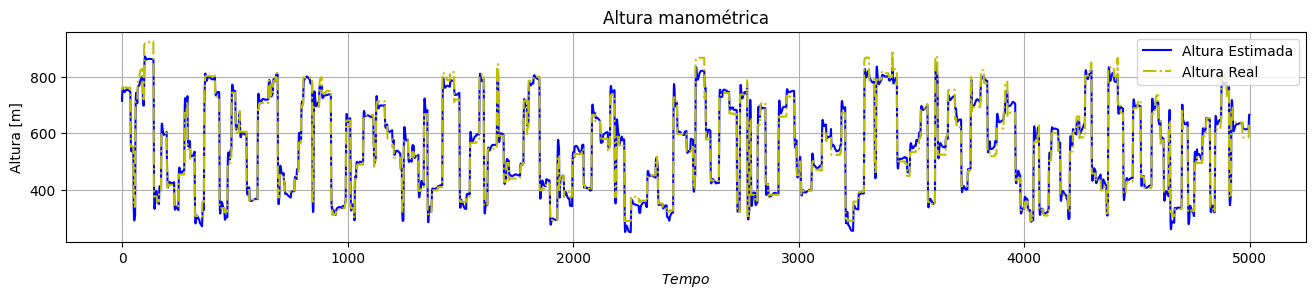

R²: [0.8298064579049018, 0.9749432296997173]
NRMSE: [0.06373869910368195, 0.041006598422471764]


In [15]:
Y_pred = BCS_model.run(Entradas_norm)

Y_pred = scaler_out.inverse_transform(Y_pred)
Saidas_norm = scaler_out.inverse_transform(Saidas_norm)

plt.figure(figsize=(16,6))
plt.subplot(2, 1, 1) 
plt.title("Pressão")
plt.xlabel("$Tempo$")
plt.ylabel("Pressão [bar]")
plt.plot(Y_pred[:,0]/(10^(5)), label="Pressão Estimada", color="blue", linestyle="-")
plt.plot(Saidas_norm[:,0]/(10^(5)), label="Pressão Real", color="y", linestyle="-.")
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(16,6))
plt.subplot(2, 1, 2) 
plt.title("Altura manométrica")
plt.xlabel("$Tempo$")
plt.ylabel("Altura [m]")
plt.plot(Y_pred[:,1], label="Altura Estimada", color="blue", linestyle="-")
plt.plot(Saidas_norm[:,1], label="Altura Real", color="y", linestyle="-.")
plt.grid()
plt.legend()
plt.show()

R2_p = r2_score(Saidas_norm[:,0], Y_pred[:,0])
R2_h = r2_score(Saidas_norm[:,1], Y_pred[:,1])
R2  = [R2_p, R2_h]
print(f"R²: {R2}")

rmse_p = NRMSE(Saidas_norm[:,0], Y_pred[:,0])
rmse_h = NRMSE(Saidas_norm[:,1], Y_pred[:,1])
nrmse = [float(rmse_p), float(rmse_h)]
print(f"NRMSE: {nrmse}")

# TESTE PRÁTICO

350


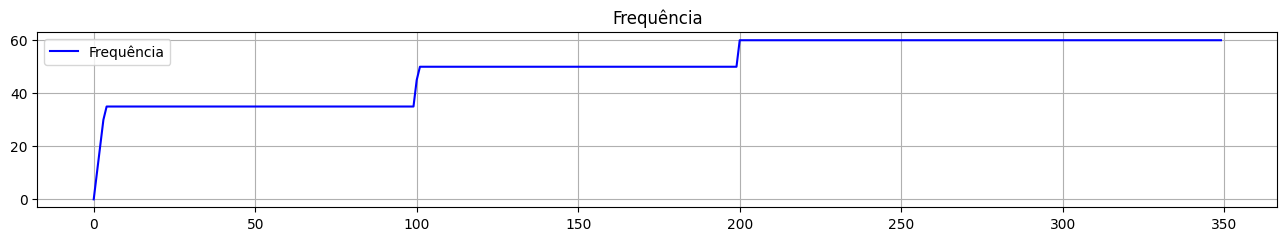

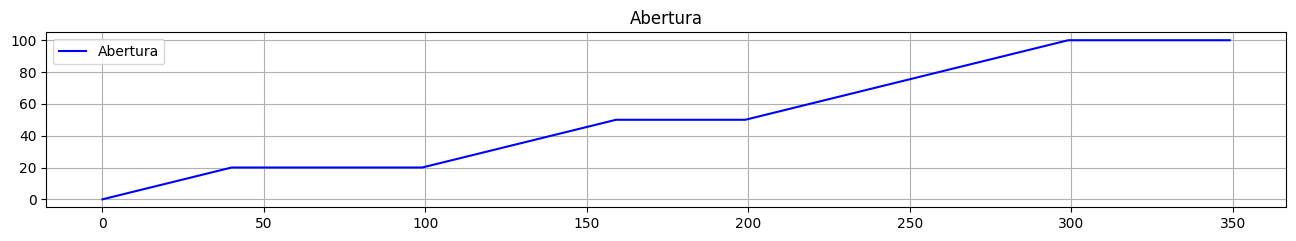

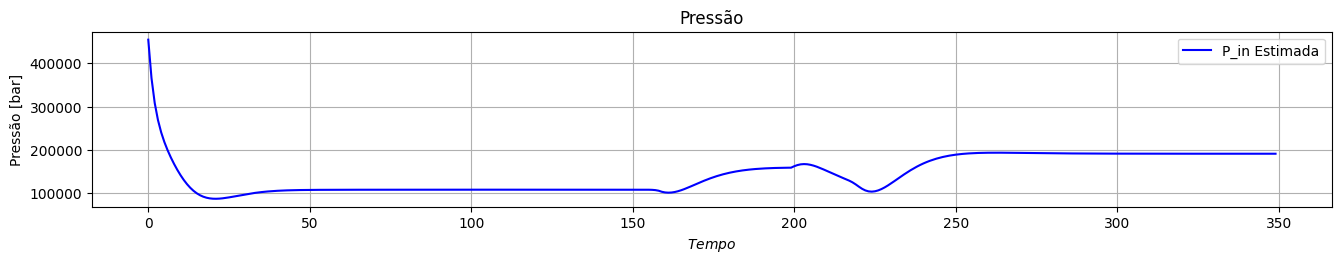

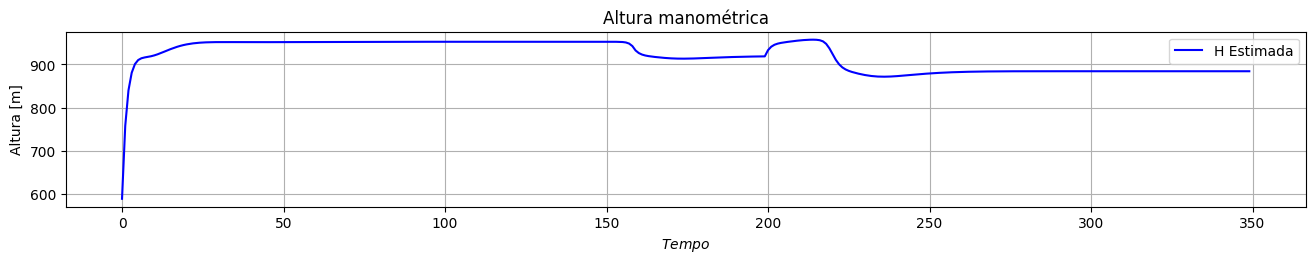

In [16]:
Saidas = pd.read_excel("Saidas_3_xlsx.xlsx")

Ts = 1;         # período de amostragem
tsim = 350;     # tempo de simulação
nsim = tsim/Ts; # numero de amostras da simulação
Input = np.array([0.00, 0.00]) # Dados iniciais

print(int(nsim))
for j in range(int(nsim)):

    tsim = j*Ts
    
    # ESP Start-up 
    if tsim > 0 and tsim < 100:
        Input = np.vstack([Input, Input[-1] + np.array([10, 0.5])])
        Input[-1] = np.minimum(Input[-1], [35, 20])
    
    if tsim > 99 and tsim < 200:
        Input = np.vstack([Input, Input[-1] + np.array([10, 0.5])])
        Input[-1] = np.minimum(Input[-1], [50, 50])

    if tsim > 199:
        Input = np.vstack([Input, Input[-1] + np.array([10, 0.5])])
        Input[-1] = np.minimum(Input[-1], [60, 100])
    

t_plt = np.arange(0, tsim+1, Ts)
Output = BCS_model.run(Input)
Output = scaler_out.inverse_transform(Output)


plt.figure(figsize=(16,5))
plt.subplot(2, 1, 1) 
plt.title("Frequência")
#plt.xlabel("$Tempo$")
#plt.ylabel("Pressão [bar]")
plt.plot(t_plt, Input[:,0], label="Frequência", color="blue", linestyle="-")
#plt.plot(t_plt, Input[:,0], label="Pressão Real", color="y", linestyle="-.")
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(16,5))
plt.subplot(2, 1, 2) 
plt.title("Abertura")
#plt.xlabel("$Tempo$")
#plt.ylabel("Altura [m]")
plt.plot(t_plt, Input[:,1], label="Abertura", color="blue", linestyle="-")
#plt.plot(t_, Y_valid[:,1], label="Altura Real", color="y", linestyle="-.")
plt.grid()
plt.legend()
plt.show()
plt.figure(figsize=(16,5))
plt.subplot(2, 1, 1) 
plt.title("Pressão")
plt.xlabel("$Tempo$")
plt.ylabel("Pressão [bar]")
plt.plot(t_plt, Output[:,0]/(10^(5)), label="P_in Estimada", color="blue", linestyle="-")
#plt.plot(t_plt, Input[:,0], label="Pressão Real", color="y", linestyle="-.")
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(16,5))
plt.subplot(2, 1, 2) 
plt.title("Altura manométrica")
plt.xlabel("$Tempo$")
plt.ylabel("Altura [m]")
plt.plot(t_plt, Output[:,1], label="H Estimada", color="blue", linestyle="-")
#plt.plot(t_, Y_valid[:,1], label="Altura Real", color="y", linestyle="-.")
plt.grid()
plt.legend()
plt.show()